<a href="https://colab.research.google.com/github/iisuslik43/dul/blob/hw2/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import os
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import numpy as np
import torch
import torch.utils.data
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
import pickle
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
def draw_losses(train_losses, test_losses):
    plt.plot(list(range(len(train_losses))), train_losses, color='r', label='train')
    plt.plot(list(range(len(test_losses))), test_losses, color='b', label='test')
    plt.legend()
    plt.show()
def sample_data():
  count = 100000
  rand = np.random.RandomState(0)
  a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
  -np.sin(np.linspace(0, np.pi, count // 3))]

  c += rand.randn(*c.shape) * 0.2
  data_x = np.concatenate([a, b, c], axis=0)
  data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
  perm = rand.permutation(len(data_x))
  return data_x[perm], data_y[perm]

In [0]:
K = 10
X, y = sample_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

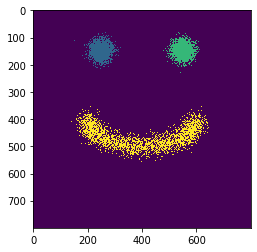

In [66]:
image = np.zeros((800, 800))
for (x1, x2), y1 in zip(X, y):
  image[int(-x2 * 100 + 400)][int(x1 * 100 + 400)] = y1 + 1
plt.imshow(image)
plt.show()

# 1 (CDF)


In [0]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, ms, bias=True):
        super().__init__(in_features, out_features, bias)
        m1, m2 = ms
        mask = m2.reshape(-1, 1) >= m1.reshape(1, -1)
        
        mask = mask.astype(np.float32)
        self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32))
        
    def forward(self, x):
        return F.linear(x, self.mask * self.weight, self.bias)

class MADE(nn.Module):
    def __init__(self, d=2, n=200, hidden_sizes=[200, 200]):
        super(MADE, self).__init__()
        self.d = d
        self.n = n
        input_size = 2
        m = [np.array([1, 2])]
        last_m = np.repeat(np.arange(self.d), self.n)
        for layer_size in hidden_sizes:
            m += [np.random.randint(m[-1].min(), d, size=layer_size)]
        layers = [
            MaskedLinear(input_size, hidden_sizes[0], m[0:2]),
            nn.ReLU()
        ]
        for i in np.arange(1, len(hidden_sizes)):
            layers += [
                MaskedLinear(hidden_sizes[i-1], hidden_sizes[i], m[i:i + 2]),
                nn.ReLU()
            ]
        
        layers += [
            MaskedLinear(hidden_sizes[-1], d * n, (m[-1], last_m))
        ]
        self.layers = nn.Sequential(*layers)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        #x = x.reshape(-1, self.d)
        x = self.layers(x)
        x = x.reshape(-1, self.d, self.n)
        return x

In [0]:
normal_distr = torch.distributions.normal.Normal(0, 1)
def normal(x, mu, sigma, pi):
  batch_size = x.shape[0]
  k = mu.shape[1]
  x = x.repeat(k).reshape(k, batch_size).transpose(0, 1)
  x = (x - mu) / sigma
  return (normal_distr.cdf(x) * pi).sum(dim=1)

def prob(x, mu, sigma, pi):
  batch_size = x.shape[0]
  k = mu.shape[1]
  x = x.repeat(k).reshape(k, batch_size).transpose(0, 1)
  norm = torch.exp(-(x - mu) ** 2 / (2 * sigma)) / (2 * np.pi * sigma) ** 0.5
  return -torch.log((norm * pi).sum(dim=-1) + 1e-9).sum()

In [0]:
class Flow(nn.Module):
    def __init__(self, k):
      super(Flow, self).__init__()
      self.pi = nn.Sequential(MADE(2, k, [k, k]), nn.Softmax(dim=-1))
      self.sigma = MADE(2, k, [k, k])
      self.mu = MADE(2, k, [k, k])

    def forward(self, x):
        x1 = x[:,0]
        x2 = x[:,1]
        # (batch_size, 2, k)
        pi, sigma, mu = self.pi(x), self.sigma(x), self.mu(x)
        sigma = sigma ** 2
        pi1, pi2 = pi[:,0,:], pi[:,1,:]
        mu1, mu2 = mu[:,0,:], mu[:,1,:]
        sigma1, sigma2 = sigma[:,0,:], sigma[:,1,:]
        z1 = normal(x1, mu1, sigma1, pi1)
        z2 = normal(x2, mu2, sigma2, pi2)
        z = torch.cat((z1, z2)).reshape(-1, 2)
        return z, pi, sigma, mu

In [0]:
class SuperLoss(nn.Module):
        
    def forward(self, x, pi, sigma, mu):
        batch_size = x.shape[0]
        pi1, pi2 = pi[:,0,:], pi[:,1,:]
        mu1, mu2 = mu[:,0,:], mu[:,1,:]
        sigma1, sigma2 = sigma[:,0,:], sigma[:,1,:]
        x1 = x[:,0]
        x2 = x[:,1]
        p1 = prob(x1, mu1, sigma1, pi1)
        p2 = prob(x2, mu2, sigma2, pi2)
        return (p1 * p2) / batch_size

In [0]:
model_flow = Flow(K).to(device)
losser = SuperLoss()
dataset_train = torch.utils.data.DataLoader(X_train, batch_size=128, shuffle=True)
dataset_test = torch.utils.data.DataLoader(X_test, batch_size=128, shuffle=True)
optimizer = torch.optim.Adam(params=model_flow.parameters())

In [72]:
train_losses = []
test_losses = []
n_epochs = 20
for epoch in tqdm(range(n_epochs)):
    epoch_train = []
    epoch_test = []
    for X_batch in dataset_train:
        X_batch = torch.tensor(X_batch, dtype=torch.float32).to(device)
        optimizer.zero_grad()
        z, pi, sigma, mu = model_flow(X_batch)
        loss = losser(X_batch, pi, sigma, mu)
        train_loss = loss.item()
        loss.backward()
        optimizer.step()
        
        epoch_train.append(train_loss)
    #     break
    # break
    with torch.no_grad():
      for test_batch in dataset_test:
        test_batch = torch.tensor(test_batch, dtype=torch.float32).to(device)
        z, pi, sigma, mu = model_flow(test_batch)
        test_loss = losser(test_batch, pi, sigma, mu).item()
        epoch_test.append(test_loss)
    train_losses.append(np.mean(epoch_train))
    test_losses.append(np.mean(epoch_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


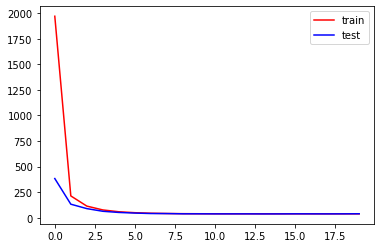

In [73]:
draw_losses(train_losses, test_losses)

In [0]:
def prob_vector(x, mu, sigma, pi):
  batch_size = x.shape[0]
  k = mu.shape[1]
  x = x.repeat(k).reshape(k, batch_size).transpose(0, 1)
  norm = torch.exp(-(x - mu) ** 2 / (2 * sigma)) / (2 * np.pi * sigma) ** 0.5
  return (norm * pi).sum(dim=1)

def get_probs(x, pi, sigma, mu):
  batch_size = x.shape[0]
  pi1, pi2 = pi[:,0,:], pi[:,1,:]
  mu1, mu2 = mu[:,0,:], mu[:,1,:]
  sigma1, sigma2 = sigma[:,0,:], sigma[:,1,:]
  x1 = x[:,0]
  x2 = x[:,1]
  p1 = prob_vector(x1, mu1, sigma1, pi1)
  p2 = prob_vector(x2, mu2, sigma2, pi2)
  return p1 * p2

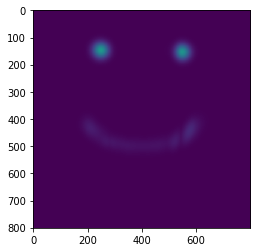

In [78]:
image = np.zeros((801, 800))
for x in tqdm(np.arange(-4, 4, 0.01)):
    xy = torch.tensor([[x, y] for y in np.arange(-4, 4, 0.01)], dtype=torch.float32).to(device)
    with torch.no_grad():
        z, pi, sigma, mu = model_flow(xy)
        proba = get_probs(xy, pi, sigma, mu).cpu().numpy()
        for (_, y), p in zip(xy, proba):
          image[int(-y * 100 + 400)][int(x * 100 + 400)] += p
        
plt.imshow(image)
plt.show()

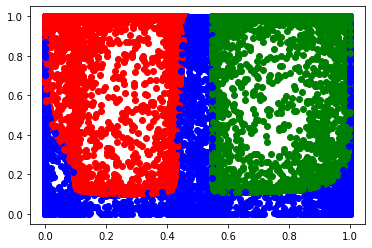

In [38]:
for x, y in tqdm(list(zip(X_test, y_test))):
  with torch.no_grad():
    xy = torch.tensor([x], dtype=torch.float32).to(device)
    z, pi, sigma, mu = model_flow(xy)
  z = z[0].cpu().numpy()
  colors = {0 : 'r', 1: 'g', 2: 'b'}
  plt.plot(z[0], z[1], colors[y] + 'o')

# 2 (RealNVP)

In [0]:
class MLLELoss(nn.Module): 
    def forward(self, x):
        return -torch.log(x + 1e-9).mean()

In [0]:
class MLP(nn.Module):
    def __init__(self, hidden_sizes=[64, 64]):
        super(MLP, self).__init__()
        layers = [nn.Linear(2, hidden_sizes[0]), nn.ReLU()]
        for i in range(1, len(hidden_sizes)):
            layers += [nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]),nn.ReLU()]
        layers += [nn.Linear(hidden_sizes[-1], 1)]
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.layers(x)
        return x


In [0]:
class CouplingLayer(nn.Module):
    def __init__(self, mask):
        super(CouplingLayer, self).__init__()
        self.mask = mask.clone()
        self.s = MLP()
        self.t = MLP()

        
    def forward(self, x):
        x_second = self.mask * x
        x_first = (1 - self.mask) * x
        s = torch.tanh(self.s(x_second))
        t = self.t(x_second)
        y = x_second + x_first * torch.exp(s) + (1 - self.mask) * t
        logdet = s.sum(dim=1)
        return y, logdet

In [0]:
class ActNorm(nn.Module):
    def __init__(self):
        super(ActNorm, self).__init__()
        self.s = nn.Parameter(torch.ones(2))
        self.t = nn.Parameter(torch.zeros(2))
        
    def forward(self, x):
        y = self.s * x + self.t
        logdet = torch.log(self.s.abs() + 1e-9).sum()
        return y, logdet

In [0]:
class RealNVP(nn.Module):
    def __init__(self, hidden_size=4):
        super(RealNVP, self).__init__()
        layers = []
        mask = torch.tensor([0, 1]).to(device)
        for i in range(hidden_size):
            layers += [CouplingLayer(mask), ActNorm()]
            mask = 1 - mask
        layers += [CouplingLayer(mask)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        logdet = torch.zeros((x.shape[0])).to(device)
        for layer in self.layers:
          x, logdet1 = layer(x)
          logdet += logdet1
        x = torch.sigmoid(x)
        logdet += torch.log(x * (1 - x) + 1e-9).sum(dim=1)
        return x, torch.exp(logdet)
        


In [58]:
model_real_nvp = RealNVP().to(device)
dataset_train = torch.utils.data.DataLoader(X_train, batch_size=128, shuffle=True)
dataset_test = torch.utils.data.DataLoader(X_test, batch_size=128, shuffle=True)
optimizer = torch.optim.Adam(params=model_real_nvp.parameters())
losser = MLLELoss()

train_losses = []
test_losses = []
n_epochs = 10
for epoch in tqdm(range(n_epochs)):
    epoch_train = []
    epoch_test = []
    for X_batch in dataset_train:
        X_batch = torch.tensor(X_batch, dtype=torch.float32).to(device)
        optimizer.zero_grad()
        output, logdet = model_real_nvp(X_batch)
        loss = losser(logdet)
        train_loss = loss.item()
        #print(logdet.min().item(), train_loss)
        loss.backward()
        optimizer.step()
        epoch_train.append(train_loss)
    with torch.no_grad():
      for test_batch in dataset_test:
        test_batch = torch.tensor(test_batch, dtype=torch.float32).to(device)
        output, logdet = model_real_nvp(X_batch)
        test_loss = losser(logdet).item()
        epoch_test.append(test_loss)
    train_losses.append(np.mean(epoch_train))
    test_losses.append(np.mean(epoch_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


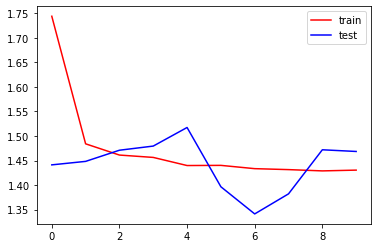

In [59]:
draw_losses(train_losses, test_losses)

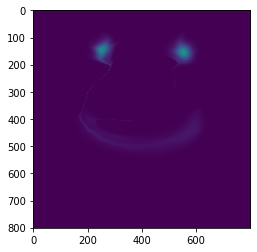

In [79]:
image = np.zeros((801, 800))
for x in tqdm(np.arange(-4, 4, 0.01)):
    xy = torch.tensor([[x, y] for y in np.arange(-4, 4, 0.01)], dtype=torch.float32).to(device)
    with torch.no_grad():
        output, logdet = model_real_nvp(xy)
        logdet = logdet.cpu().numpy()
        for (_, y), p in zip(xy, logdet):
          image[int(-y * 100 + 400)][int(x * 100 + 400)] += p
        
plt.imshow(image)
plt.show()

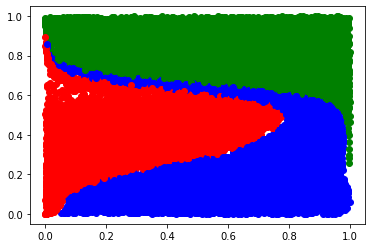

In [61]:
for x, y in tqdm(list(zip(X_test, y_test))):
  with torch.no_grad():
    xy = torch.tensor([x], dtype=torch.float32).to(device)
    z, logdet = model_real_nvp(xy)
  z = z.cpu().numpy()[0]
  colors = {0 : 'r', 1: 'g', 2: 'b'}
  plt.plot(z[0], z[1], colors[y] + 'o')